# Strategy for Lifting Non-Pharmaceutical Implementations
This notebook explores a decision support tool, which schedules the lifting of imposed restrictions. The basic idea is to only lift restrictions when a forward simulation guarantees that the load on the health-care system stays below a certain threshold.

The simulation is done by the Epidexus agent-based simulation engine. At certain intervals, the population is tested and a probabilistic estimator predicts the estimated mean and variance of the SEIR parameters.

## Setting up the Simulation
First we will set up a very simplified simulation with everybody in the same home location and empty itineraries. We will start out with 1000 people and infect the first 10.

In [1]:
from epidexus import EpidexusModel
from epidexus.world_creation import create_family
from epidexus.scenarios.onelocation import OneLocation

from datetime import datetime, timedelta
import numpy.random

poulation_size = 1000
infected_people = 10
infection_rate = 0.5
start_date = datetime(2020, 3, 31)
scenario = OneLocation(poulation_size, infected_people, infection_rate, start_date)
scenario.set_seed(0)

## Setup a Strategy

The strategy is just a list of tuples of restriction values and the duration it should be enforced. A restriction value 1 is full restriction and 0 is none.

In [2]:
strategy = [(0,timedelta(days=10)),
            (1/2,timedelta(days=30)),
            (1/3,timedelta(days=20)),
            (1/6,timedelta(days=10)),
            (0,timedelta(days=20))]

## Run the Simulation

We will run through each part of the strategy. First, unpacking and applying the restriction value then simulating the associated time interval.

In [3]:
for s in strategy:
    scenario.control_variable = s[0]
    scenario.simulate(s[1])

## Plotting the output
Let's see if things look right. First the stackplot:

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ab88162c70>)

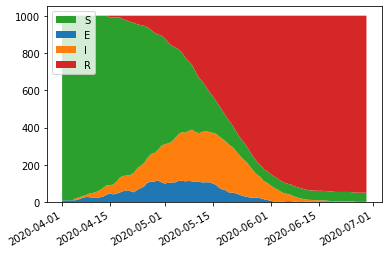

In [4]:
from epidexus.plotting import seir_stackplot, infected_plot
seir_stackplot(scenario.sim_model)


We will run a reference simulation with the same parameters but without the strategy enforced, and plot the two infected portions against each other:

In [5]:
scenario_ref = OneLocation(poulation_size, infected_people, infection_rate, start_date)
scenario_ref.set_seed(0)

total_interval = timedelta()
for s in strategy:
    total_interval += s[1]
scenario_ref.simulate(total_interval)

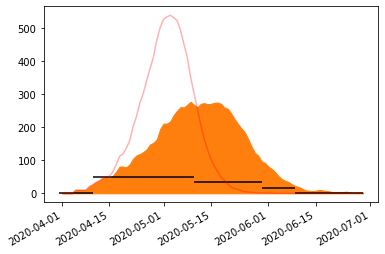

In [6]:
import matplotlib.pyplot as plt
from itertools import accumulate

fig, ax = plt.subplots()
fig.autofmt_xdate()

seir = scenario.sim_model.datacollector.get_model_vars_dataframe()
ax.fill_between(seir["Date"], seir["I"], color='C1')

seir_ref = scenario_ref.sim_model.datacollector.get_model_vars_dataframe()
ax.plot(seir_ref["Date"], seir_ref["I"], color='r', alpha=0.3)

strat_dates = list(accumulate([start_date]+[s[1] for s in strategy]))
ax.hlines([s[0]*100 for s in strategy], strat_dates[0:-1], strat_dates[1:])

*Note that the implementation strategy has been scaled by 100.*